### Current Environment (Windows):
IPython          : 8.27.0  ipykernel        : 6.29.5  ipywidgets       : 8.1.5  jupyter_client   : 8.6.2  jupyter_core     : 5.3.0  jupyter_server   : 2.14.2  jupyterlab       : 4.2.5  nbclient         : 0.10.0  nbconvert        : 7.16.4  nbformat         : 5.8.0  notebook         : 7.2.2  qtconsole        : not installed  traitlets        : 5.14.3  

### Requirements
The project in presentation slides (50%) (PowerPoint or Google Slides). 
Here is a general outline for presenting a data science project in a slide deck:

  
Data requirements are **Country**, **Wheat value** and **Year**, plotting the country's production over multiple years.    
We could do three seperate axes (subplots) to one frame - one bar for each year for example: 
![title](threeBars.png)  
`figure, axis = plt.subplots(3, 1)`  
[Frame & Subplots](https://stackoverflow.com/questions/62375119/how-to-add-a-border-or-frame-around-a-figure-and-subplots)
  
With that being said, Im going to create a line graph, one uniquely coloured line per individual country, with the  
values plotted tons (up) years (across) and the ability to isolate & hide individual lines.  
This is intended more as an app-centric (interactive) display rather than a jupyter still image.  

## NOTE:  
This is intended to be run from a python shell.  It WILL run inside the jupyter notbook, however it will not run interactively and the extra work will be lost. An attempt was made to ensure it will work on OSX and Windows, using the pip requirements.txt, however I do not currently own an OSX machine, so this is untested.   

### SETUP  
Using pip to setup the python environment
CD into the github directory and using the requirements.txt call:  
`pip install -r requirements.txt`  
This should install all of the required modules if any are missing.  
Once installed it can be run from a python console:  
![Run Python](BONUS_setup.png) 

In [1]:
%matplotlib ipympl
#This is used as an attempt to run jupyter interactively
import pandas
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.backend_tools import ToolBase
import matplotlib as mpl
mpl.rcParams['toolbar'] = 'toolmanager'


C:\Users\Trevor\AppData\Local\Temp\ipykernel_10680\3741922460.py:8: UserWarning: Treat the new Tool classes introduced in v1.5 as experimental for now; the API and rcParam may change in future versions.
  mpl.rcParams['toolbar'] = 'toolmanager'


Imported ToolBase and set toolManager to access the tool buttons in the main window. Now Load wheat Dataframe

In [3]:
wheat_production_url = r'https://en.wikipedia.org/wiki/List_of_countries_by_wheat_production'
wheat_query = pandas.read_html(wheat_production_url)
wheat_df = wheat_query[0]


Data prep. Clip and transpose to give the X and Y axis we require.  
**NOTE:** `plt.close()` clears any data currently lurking in the pyplot instance  

In [4]:
# remove totals row as this throws everything off and remove everything after 2019
clipped = wheat_df.iloc[1:, :4]
gaa = clipped.set_index("Country")
# swap columns and rows
gaa = gaa.transpose()
# erase anything already existing in pyplot
plt.close()

Extract reqiuired objects into more accessable variable names.  
**NOTE:** .plot() sets up the axis and Figure instances of the pyplot object. The data within these instances is **LOST** when the `plt.show()` is called unless we make a reference to it here.  
`Figure.show()` can be called subsequently, if we DO make a reference to it, but this figure **DOES NOT** contain any of the global window items (it is the figure only), such as the toolbar - will cause the code to error if we try to access parts of the non-existent windows

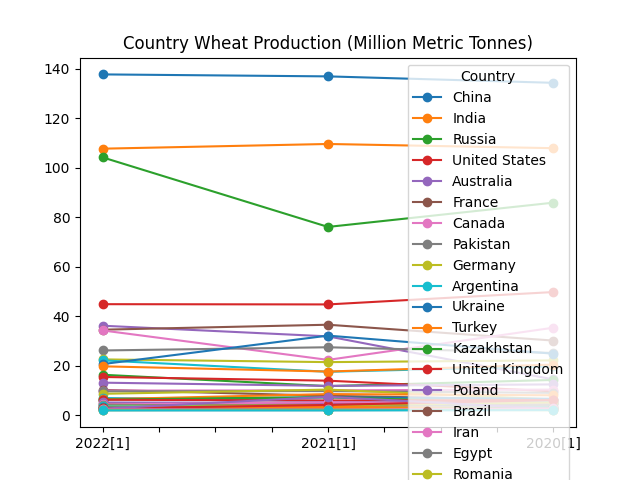

In [5]:
# plot the data into pyplot. This returns the axis
axis = gaa.plot(title="Country Wheat Production (Million Metric Tonnes)", marker = 'o')
# capture the items we are going to use
legend = axis.get_legend()
legend.set_loc("upper right")
legend.set_draggable(True)
current_figure = plt.gcf()
tool_manager = current_figure.canvas.manager.toolmanager
toolbar = current_figure.canvas.manager.toolbar

axis_lines = axis.get_lines()
legend_texts = legend.get_texts()
legend_lines = legend.get_lines()
map_legend_to_ax = {}
map_text_to_ax = {}
pickradius = 2  # Points (Pt)
# made global so population functions can access
global isolated
isolated = 0



Set up initial LIne2D s so they are mapped and can be clicked
**NOTE:** This is interactive only and will have no effect on the image only representations shown in jupyter

In [6]:
# here we assume the legend and the axis correspond to each other
for legend_line, ax_line in zip(legend_lines, axis_lines):
    legend_line.set_picker(pickradius)  # Enable picking on the legend line.
    ax_line.set_picker(pickradius)  # Enable picking on the axis line.
    map_legend_to_ax[legend_line] = ax_line

Next add the Refresh button Action. This is an overloaded template class that performs a custom trigger() action

In [7]:
#ToolBase = None
class RefreshTool(ToolBase):
    """
    Overloaded default ToolBase class that resets ALL lines to visible.
    Note: many of the items are assumed to have GLOBAL scope and 
    available here
    """
    def trigger(self, *args, **kwargs):
        global isolated
        for legend_line, axisLine in zip(legend_lines, axis_lines):
            axisLine.set_visible(True)
            axisLine.set_markersize(0.2)
            ax_line.set_picker(2) 
            legend_line.set_alpha(1.0)
            annotation_box.set_visible(False)
            #record that all items are shown
            isolated = 0

        current_figure.canvas.draw()

Set up annotation box to give exact values when clicked (hidden by default)

In [8]:
annotation_box = axis.annotate("", xy=(0,0), xytext=(20,20), textcoords="offset points",
                    bbox=dict(boxstyle="round", fc="w"),
                    arrowprops=dict(arrowstyle="->"))
annotation_box.set_visible(False)


#canvas_manager = current_figure.canvas.manager
#tool_manager = canvas_manager.toolmanager
#toolbar = canvas_manager.toolbar
# jupyter backend sometimes does not allow interactive matplotlib
#if toolbar:
#    tool_manager.add_tool("Refresh", RefreshTool)
#    toolbar.add_tool(tool_manager.get_tool("Refresh"), "toolgroup")


# create refresh button and add it to the toolbar
#tool_manager.add_tool("Refresh", RefreshTool)
#current_figure.canvas.manager.toolbar.add_tool(tool_manager.get_tool("Refresh"), "toolgroup")

onPick event. When a legend line is clicked, call this overridden function.  
This will allow specific lines or groups of lines to be shown independently 

In [9]:
def on_pick(event):
    """
    Legend items and axis items have pick enabled above.
    This function is called when an item is picked.

    We are differentiating between Legend items and axis items
    Axis item onPick shows Line2d name and value under mouse in annotation box
    Legend items onPick sets item as isolated (hides everything else)
    NOTE: there is logic to allow multiple lines to be shown in isolation
    this also turns off the onPick for hidden items
    """

    legend_item = event.artist
    ax_line = None
    global isolated
    # if the source is in the legend 
    if legend_item in map_legend_to_ax :
        ax_line = map_legend_to_ax[legend_item]
    elif legend_item in axis_lines:
        # if it is in main window, show the annotation box with values
        item_data = legend_item.get_data()
        contains, item_index = legend_item.contains(event.mouseevent)
        current_value = (str(item_data[1][item_index['ind'][0]]))
        item_text = str(legend_item).replace("Line2D(", "").replace(")", "")
        item_text = item_text + " " + current_value
        annotation_box.set_text(item_text)
        event_position = (float(event.mouseevent.x), float(event.mouseevent.y))
        annotation_box.set_visible(True)
        current_figure.canvas.draw()
        return
    else:
        return
    
    # if we get here we are a Legend item
    # flag we have isolated an item
    isolated += 1
    for legend_line, axisLine in map_legend_to_ax.items():
        visible = not axisLine.get_visible()
        alpha = 1.0 if visible else 0.2
        markersize = 10 if not visible else 2
        # check that this one is the selected one. If so show it
        if legend_item == legend_line:
            axisLine.set_visible(True)
            axisLine.set_picker(2) 
            axisLine.set_markersize(3)
            legend_item.set_alpha(1.0)
        else:
            #if we have isolated something previously and the visible is on, leave this item
            # as we are showing multiple isolations
            current_viisibility = axisLine.get_visible()
            show_item = bool(bool(isolated>1) and current_viisibility) 

            if not show_item:
                axisLine.set_visible(False)
                axisLine.set_markersize(2)
                axisLine.set_picker(False) 
            legend_item.set_alpha(alpha)    
    current_figure.canvas.draw()

onPress event. This is an attempt to capture a keypress to be able to refresh  
the view, showing all lines avoiding the need for a tool button

In [10]:
def on_press(event):
    """
    Keypress event monitoring. 
    """
    print (event.key)
    if (event.key == "z"):
        # reset "R" keypress.
        # reset all visibility to ON
        print ("R RPESS")
        global isolated
        for legend_line, axisLine in zip(legend_lines, axis_lines):
            axisLine.set_visible(True)
            axisLine.set_markersize(0.2)
            ax_line.set_picker(2) 
            legend_line.set_alpha(1.0)
            annotation_box.set_visible(False)
            #record that all items are shown
            isolated = 0

        current_figure.canvas.draw()


Connect the pick_event to the onPick function and show the window

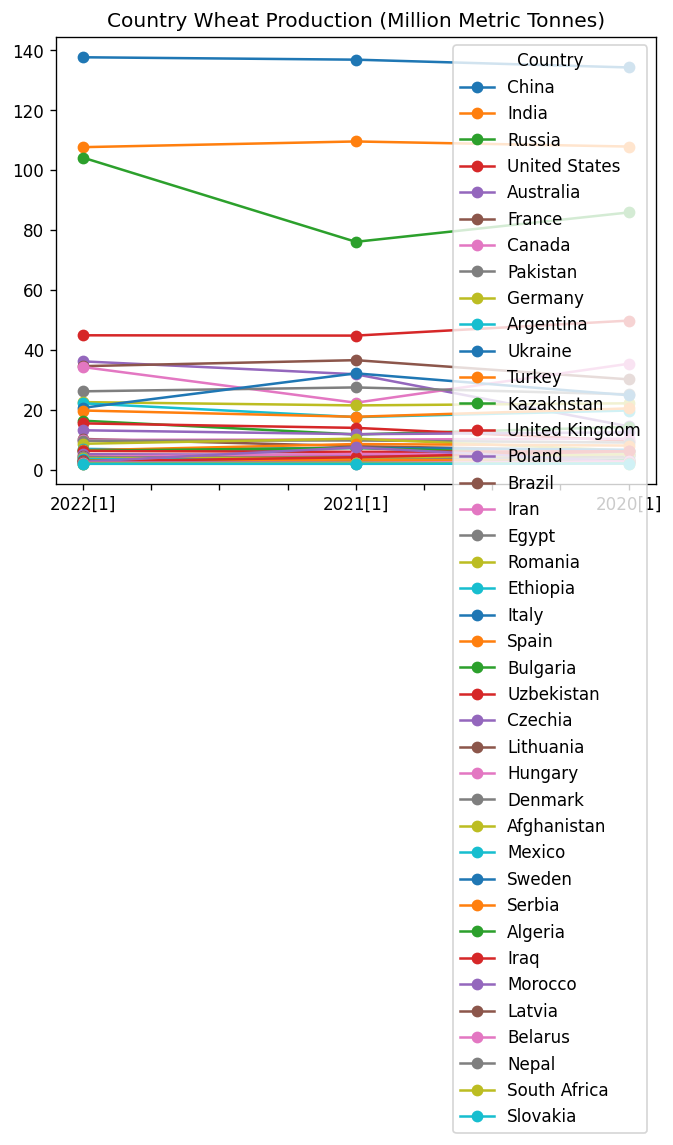

In [11]:
current_figure

### IN USE:
![Run Python](BONUS_features.png)  
Clicking the Icon next to the country name on the right will isolate the country's line. This can be pressed for multiple countries to create a subset of all countrys data.  
Pressing the "r" button on the keyboard will reset the view, alloing all couintries ot be shown.  
Clicking a line's plot will show the line's country name and its value in an annotation box at the bottom left of the screen.  
The legend on the right can be dragged into any area.  